In [32]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [21]:
pth = "met_gas_site_cleaned.snappy.parquet"
def generate_datasets(pth):

  df = pd.read_parquet(pth)
  df["year"] = df["DATE_TIME"].dt.year
  df["month"] = df["DATE_TIME"].dt.month
  df["LATITUDE"] = df["LATITUDE"].astype("float")
  df["LONGITUDE"] = df["LONGITUDE"].astype("float")

  categorical_columns = ['LAND_USE', 'TERRAIN']
  for feature in categorical_columns:
      encoder = OneHotEncoder()
      encoded_data = encoder.fit_transform(df[[feature]])
      df[encoder.categories_[0]] = encoded_data.toarray()


  drop_columns = ['OZONE', "year", "DATE_TIME", "SITE_ID", "QA_CODE", "WINDSPEED", "SIGMA_THETA"] + categorical_columns
  df_train = df[df['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
  X_train, y_train = df_train.drop(columns=drop_columns, axis=1), df_train['OZONE']

  columns = X_train.columns

  numerical_features = ['TEMPERATURE',
                        'RELATIVE_HUMIDITY',
                        'SOLAR_RADIATION',
                        'PRECIPITATION',
                        'WIND_DIRECTION',
                        'FLOW_RATE',
                        'WINDSPEED_SCALAR',
                        'SHELTER_TEMPERATURE',
                        'NO',
                        'NOY',
                        'NOYDIF',
                        'SO2_GA',
                        'LATITUDE',
                        'LONGITUDE',
                        'ELEVATION']

  ct = ColumnTransformer([
          ('Standardize Numerical Features', StandardScaler(), numerical_features)
      ], remainder='passthrough')
  X_train = ct.fit_transform(X_train)


  df_val = df[df['year'].isin([2019, 2020])]
  X_val, y_val = df_val.drop(columns=drop_columns, axis=1), df_val['OZONE']
  X_val = ct.transform(X_val)

  df_test = df[df['year'].isin([2021, 2022])]
  X_test, y_test = df_test.drop(columns=drop_columns, axis=1), df_test['OZONE']
  X_test = ct.transform(X_test)

  return columns, X_train, y_train, X_val, y_val, X_test, y_test

columns, X_train, y_train, X_val, y_val, X_test, y_test = generate_datasets(pth)

In [22]:
# Evaluate function to report train, validation, and test R2 scores for the model
def evaluate(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)
    print('R2 score for train set:', r2_score(y_train, train_preds))
    print('R2 score for validation set:', r2_score(y_val, val_preds))
    print('R2 score for test set:', r2_score(y_test, test_preds))

In [23]:
# Initial model without hyper tuning
init_model = XGBRegressor(random_state=7)
init_model.fit(X_train, y_train)
evaluate(init_model)

R2 score for train set: 0.877425958364162
R2 score for validation set: 0.7632582863555222
R2 score for test set: 0.7443330370162355


Initial XGBoost model has shown a great potential in given data set. Then, we would hyper tuning the parameters to improve the model performance.

In [24]:
# Set up the hyperparameters to grid search
hyper_paras = {'learning_rate': [0.05, 0.10, 0.15, 0.2, 0.25],
              'n_estimators': [50, 100, 150, 200, 250],
              'max_depth': [5, 10, 15, 20, 25]}

In [7]:
# using train_validation tuning
optim_params = []
TV_score = -1000000
for lr in hyper_paras['learning_rate']:
    for ne in hyper_paras['n_estimators']:
        for md in hyper_paras['max_depth']:
            TV_model = XGBRegressor(random_state=7, learning_rate=lr, n_estimators=ne, max_depth=md)
            TV_model.fit(X_train, y_train)
            val_preds = TV_model.predict(X_val)
            new_score = r2_score(y_val, val_preds)
            if new_score > TV_score:
                optim_params = [lr, ne, md]
                TV_score = new_score

print('Optimal learning rate:', optim_params[0])
print('Optimal number of estimators:', optim_params[1])
print('Optimal maximum depth:', optim_params[2])

TV_optim = XGBRegressor(random_state=7, learning_rate=optim_params[0], n_estimators=optim_params[1], max_depth=optim_params[2])
TV_optim.fit(X_train, y_train)
evaluate(TV_optim)

Optimal learning rate: 0.05
Optimal number of estimators: 100
Optimal maximum depth: 10
R2 score for train set: 0.9039328988991843
R2 score for validation set: 0.7746348177945424
R2 score for test set: 0.7626106523419462


We choose 3 hyperparameters with 5 different values each and train the model using train set. After that, we compare the performance on the validatoin set and try to find the optimal parameters for the model. We could see the R2 scores for all three sets are increasing with optimal hyperparameters

In [42]:
sorted(zip(TV_optim.feature_importances_, columns), reverse=True)[:3]

[(0.7292984, 'ELEVATION'),
 (0.09859362, 'RELATIVE_HUMIDITY'),
 (0.033972543, 'Complex')]

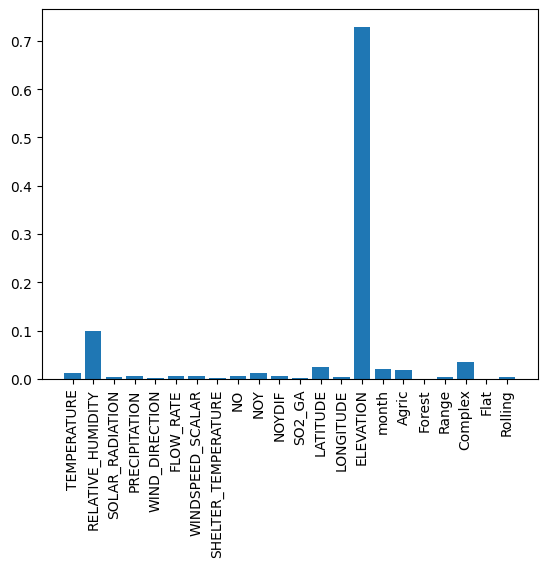

In [29]:
# Plot the feature importance by the inner function of XGBoost
plt.bar(columns, TV_optim.feature_importances_)
plt.xticks(rotation=90)
plt.show()

The top 3 important features are Elevation, Relative_Humidity, and Complex.

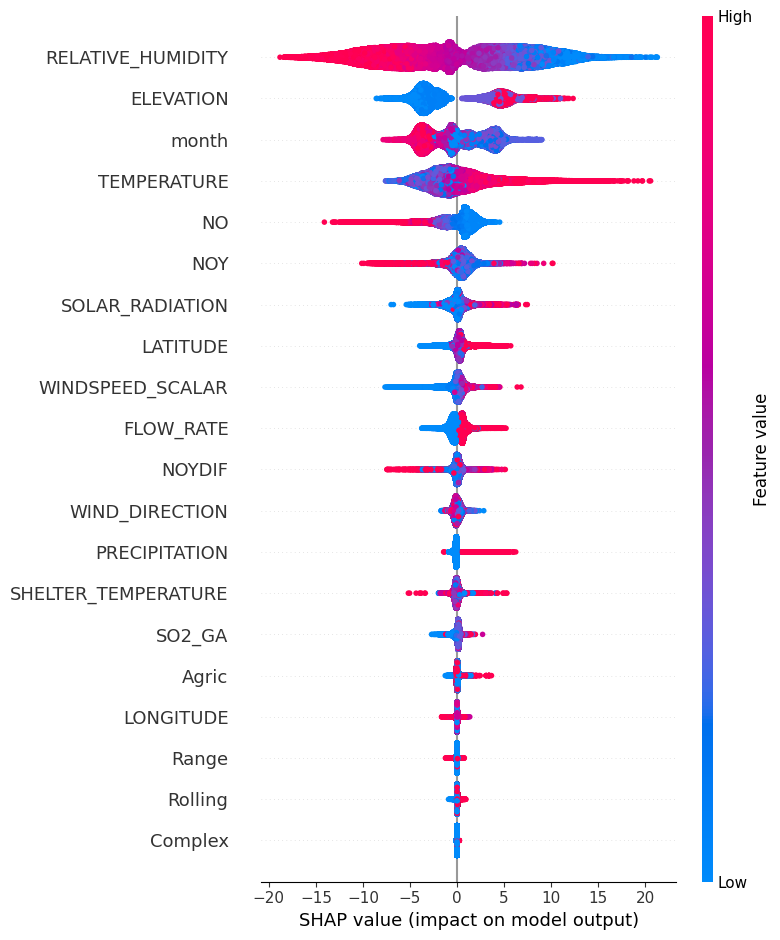

In [41]:
# Plot the feature importance by SHAP
explainer = shap.Explainer(TV_optim)
shap_values = explainer(X_train)

X = pd.DataFrame(X_train, columns=columns)
shap.summary_plot(shap_values, X)

The top 3 important features are Relative_Humidity, Elevation, and month.

In [6]:
# Use cross-validation with time split
CV_model = GridSearchCV(XGBRegressor(random_state=7, early_stopping_rounds=10), 
                         hyper_paras, 
                         cv=TimeSeriesSplit(n_splits=3),
                         verbose=1,
                         scoring='r2')

# Use the validation set for early stopping
CV_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
print(CV_model.best_score_, CV_model.best_params_)

CV_optim = CV_model.best_estimator_
CV_optim.fit(X_train, y_train, eval_set=[(X_val, y_val)])
evaluate(CV_optim)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
0.883971783873081 {'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 150}
[0]	validation_0-rmse:11.76266
[1]	validation_0-rmse:11.32616
[2]	validation_0-rmse:10.92049
[3]	validation_0-rmse:10.53647
[4]	validation_0-rmse:10.17888
[5]	validation_0-rmse:9.85067
[6]	validation_0-rmse:9.53776
[7]	validation_0-rmse:9.25025
[8]	validation_0-rmse:8.97886
[9]	validation_0-rmse:8.73089
[10]	validation_0-rmse:8.49872
[11]	validation_0-rmse:8.28540
[12]	validation_0-rmse:8.08626
[13]	validation_0-rmse:7.90203
[14]	validation_0-rmse:7.72884
[15]	validation_0-rmse:7.57160
[16]	validation_0-rmse:7.42525
[17]	validation_0-rmse:7.29202
[18]	validation_0-rmse:7.16520
[19]	validation_0-rmse:7.05171
[20]	validation_0-rmse:6.94567
[21]	validation_0-rmse:6.85079
[22]	validation_0-rmse:6.76399
[23]	validation_0-rmse:6.68449
[24]	validation_0-rmse:6.60929
[25]	validation_0-rmse:6.54245
[26]	validation_0-rmse:6.48279
[27]	validation_0-rmse:6.

We tried cross-validation using time-series split to find the optimal parameters. Comparing to the train validation spllit, Cross Validation model has a higher performance on the training data set, but it has lower perofermance on validation and test set, which has overfitting problem. 